In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
artists = 'dataset/artists.csv'
tracks = 'dataset/tracks.csv'

index_col = 0
df_artists = pd.read_csv(artists, sep=';', index_col=index_col)
df_tracks = pd.read_csv(tracks, index_col=index_col)

pd.set_option('display.max_columns', None)

## 💾 Optimizing Data Types for Efficiency

Before we proceed with cleaning and analysis, it's essential to ensure our DataFrames use the most **memory-efficient and appropriate data types**. Converting low-cardinality string columns (like `gender` and `nationality`) to the **`category`** dtype significantly reduces memory usage.

We'll also ensure all date columns are correctly parsed as **`datetime`** objects, and descriptive text fields are designated as the modern **`string`** dtype. For integer columns that contain `NaN` values, we use the nullable integer type **`Int64`**.

This step makes subsequent operations faster and more memory-friendly.

In [3]:
df_artists['gender'] = df_artists['gender'].astype('category')
df_artists['nationality'] = df_artists['nationality'].astype('category')
df_artists['country'] = df_artists['country'].astype('category')
df_artists['region'] = df_artists['region'].astype('category')
df_artists['province'] = df_artists['province'].astype('category')
df_artists['birth_place'] = df_artists['birth_place'].astype('category')
df_artists['birth_date'] = pd.to_datetime(df_artists['birth_date'], errors='coerce')
df_artists['active_start'] = pd.to_datetime(df_artists['active_start'], errors='coerce')
df_artists['description'] = df_artists['description'].astype('string')
df_artists['name'] = df_artists['name'].astype('string')

In [4]:
df_tracks['id_artist'] = df_tracks['id_artist'].astype('category')
df_tracks['id_album'] = df_tracks['id_album'].astype('category')
df_tracks['language'] = df_tracks['language'].astype('category')
df_tracks['album_type'] = df_tracks['album_type'].astype('category')
df_tracks['stats_pageviews'] = pd.to_numeric(df_tracks['stats_pageviews'], errors='coerce')
df_tracks['year'] = pd.to_numeric(df_tracks['year'], errors='coerce')
df_tracks['month'] = pd.to_numeric(df_tracks['month'], errors='coerce')
df_tracks['day'] = pd.to_numeric(df_tracks['day'], errors='coerce')
df_tracks['popularity'] = pd.to_numeric(df_tracks['popularity'], errors='coerce')
df_tracks['disc_number'] = df_tracks['disc_number'].astype('Int64')
df_tracks['track_number'] = df_tracks['track_number'].astype('Int64')
df_tracks['explicit'] = df_tracks['explicit'].astype('bool')
df_tracks['modified_popularity'] = df_tracks['modified_popularity'].astype('bool')
df_tracks['album_release_date'] = pd.to_datetime(df_tracks['album_release_date'], errors='coerce')
df_tracks['name_artist'] = df_tracks['name_artist'].astype('string')
df_tracks['full_title'] = df_tracks['full_title'].astype('string')
df_tracks['title'] = df_tracks['title'].astype('string')
df_tracks['featured_artists'] = df_tracks['featured_artists'].astype('string')
df_tracks['primary_artist'] = df_tracks['primary_artist'].astype('string')
df_tracks['album_name'] = df_tracks['album_name'].astype('string')
df_tracks['album'] = df_tracks['album'].astype('string')
df_tracks['album_image'] = df_tracks['album_image'].astype('string')
df_tracks['lyrics'] = df_tracks['lyrics'].astype('string')

In [5]:
import ast # Import the Abstract Syntax Tree module for safe evaluation

# Assuming your DataFrame is df_tracks and it's already loaded

def safe_literal_eval(value):
    """
    Safely converts a string representation of a list into a Python list.
    Handles NaN/missing values by returning an empty list or pd.NA.
    """
    if pd.isna(value) or value in (None, 'NaN', ''):
        # Return an empty list for missing values if you plan to iterate over it
        return []
    try:
        # Use ast.literal_eval for safe conversion of string-to-list
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        # Handle cases where the string is malformed or not a list structure
        print(f"Warning: Could not convert value: {value}")
        return [] # Default to empty list on failure

# Apply the conversion to both columns
df_tracks['swear_IT_words'] = df_tracks['swear_IT_words'].apply(safe_literal_eval)
df_tracks['swear_EN_words'] = df_tracks['swear_EN_words'].apply(safe_literal_eval)

## 🕵️ Data Validation: Checking and Correcting Primary Key Duplicates

For the data preparation phase, we start by performing a crucial check of the primary IDs for rows in both our DataFrames to check for potential duplicates. Ensuring unique identifiers is **foundational** for reliable joins and accurate analysis later on. 

A formal review of the primary ID columns yielded the following observations:

* **`df_tracks`**: Inspection of the track ID column revealed **73 instances of duplicated identifiers**. To guarantee that each record is uniquely identifiable and to maintain the principle of one-to-one entity mapping, these duplicated rows will be managed immediately. IDs are of the format $\text{TR\#\#\#\#\#\#}$, so we generate new IDs compliant with this format to replace duplicated ones.
* **`df_artists`**: The artist ID column was found to be **entirely sound**, presenting no instances of duplicate IDs. Consequently, no corrective action is required for this DataFrame regarding its primary keys.

The code below first validates the counts, displays a sample of the duplicates, and then executes the custom logic to **generate unique, non-colliding IDs** to replace the duplicated indices in `df_tracks`.

In [6]:
# 1. Creare un set di tutti gli ID esistenti per un controllo rapido
existing_tracks_ids = set(df_tracks.index)
existing_artists_ids = set(df_artists.index)

# 2. Identificare le posizioni (indice booleano) degli indici duplicati.
#    Usiamo keep='first' per segnare solo la seconda, terza, ecc. occorrenza.
duplicate_mask_tracks = df_tracks.index.duplicated()
duplicate_mask_artists = df_artists.index.duplicated()
num_duplicates_tracks = duplicate_mask_tracks.sum()
num_duplicates_artists = duplicate_mask_artists.sum()
print("number of duplicate index for tracks:", num_duplicates_tracks)
print("number of duplicate index for artists:", num_duplicates_artists)

number of duplicate index for tracks: 73
number of duplicate index for artists: 0


In [7]:
# 1. Creare una maschera per identificare TUTTE le righe (inclusa la prima)
#    che hanno un indice duplicato.
all_duplicates_mask = df_tracks.index.duplicated(keep=False)

# 2. Filtrare il DataFrame per ottenere solo queste righe
df_duplicate_groups = df_tracks[all_duplicates_mask]

# 3. Ordinare per indice. Questo è fondamentale per vedere
#    le righe con lo stesso indice una accanto all'altra.
df_duplicate_groups_sorted = df_duplicate_groups.sort_index()

# 4. Stampare i gruppi di duplicati
if not df_duplicate_groups_sorted.empty:
    print("Mostro tutte le righe che hanno un indice duplicato, ordinate per ID:")
    # Stampiamo le prime 30 (o modifica il numero se vuoi vederne di più)
    print(df_duplicate_groups_sorted.head(10))
else:
    # Questo scenario si verifica se num_duplicates (dal tuo codice) era 0
    print("Nessuna riga con indice duplicato trovata.")

Mostro tutte le righe che hanno un indice duplicato, ordinate per ID:
            id_artist      name_artist  \
id                                       
TR108862  ART56320683    Bassi Maestro   
TR108862  ART07127070      Noyz Narcos   
TR135764  ART73965015           Ghemon   
TR135764  ART86549066       Emis Killa   
TR190585  ART78209349             Coez   
TR190585  ART66932389           Piotta   
TR192351  ART81071062        Club Dogo   
TR192351  ART88792008    Jake La Furia   
TR205970  ART80977821  Jack The Smoker   
TR205970  ART08456301          Rancore   

                                                 full_title  \
id                                                            
TR108862                         Sushi Bar by Bassi Maestro   
TR108862                    SPINE by Noyz Narcos (Ft. Coez)   
TR135764                   Nessuno vale quanto te by Ghemon   
TR135764          Giovani eroi by Emis Killa (Ft. Not Good)   
TR190585     Nei treni la notte by Coez (Ft. Fr

In [8]:
import random

# --- 1. Identify Duplicated Rows and Count ---
# Find the boolean mask for rows where the ID (index) is duplicated,
# keeping only the duplicates *after* the first occurrence.
duplicated_mask = df_tracks.index.duplicated(keep='first')
num_duplicates_to_replace = duplicated_mask.sum() # Should be 73
print(num_duplicates_to_replace)

# --- 2. Define ID Generation Helper ---
def format_track_id(number, prefix='TR', padding=6):
    """Formats a number into a TRXXXXXX string."""
    # Uses f-string formatting to zero-pad the number to 6 digits
    return f"{prefix}{number:0{padding}d}"

# --- 3. Generate New Unique IDs with Collision Check ---

# Convert the existing index to a set for O(1) average time complexity lookups
existing_ids = set(df_tracks.index)
new_track_ids = []

# Range for 6-digit numbers (000000 to 999999)
MIN_ID = 0
MAX_ID = 999999 

print(f"Generating {num_duplicates_to_replace} random unique IDs...")

while len(new_track_ids) < num_duplicates_to_replace:
    # Generate a random 6-digit number
    random_num = random.randint(MIN_ID, MAX_ID)
    
    # Format it to the "TRXXXXXX" string
    new_id = format_track_id(random_num)
    
    # Check for collision against all existing IDs
    if new_id not in existing_ids:
        new_track_ids.append(new_id)
        # Immediately add the new ID to the existing_ids set to prevent
        # generating the same random ID twice during this loop
        existing_ids.add(new_id)

print("Finished generating unique IDs.")

# --- 4. Replace Duplicated IDs in the DataFrame Index ---

# Get the actual index values that need to be replaced (the index values of the duplicated rows)
indices_to_replace = df_tracks.index[duplicated_mask]

# Create a Series of the new IDs, matching the indices (positions) of the duplicated rows
new_ids_series = pd.Series(
    new_track_ids,
    index=indices_to_replace
)

# Replace the duplicated index values in-place
df_tracks.index.values[duplicated_mask] = new_ids_series.values

# --- Verification ---
print(f"\nGenerated {len(new_track_ids)} new unique IDs.")
print(f"Example new ID: {new_track_ids[0]}")
print(f"Check for duplicates after replacement: {df_tracks.index.duplicated().any()}")

73
Generating 73 random unique IDs...
Finished generating unique IDs.

Generated 73 new unique IDs.
Example new ID: TR113069
Check for duplicates after replacement: False


## 🧹 Removing Redundant Artist Columns

We discovered that **`name_artist`**, **`name`**, and **`primary_artist`** all highlight the same information, creating unnecessary redundancy in our dataset. To determine which columns to keep, we performed a thorough **normalization and comparison analysis**.

After joining the tracks and artists DataFrames, we implemented a **helper function** to normalize all artist-related string columns. This normalization process includes:
- Converting to lowercase
- Removing accents (e.g., 'è' → 'e')  
- Stripping special characters
- Trimming whitespace

We applied this normalization to **`name`**, **`primary_artist`**, **`name_artist`**, and **`featured_artists`** to ensure a fair comparison. Our analysis revealed that **`primary_artist`** and **`name_artist`** are *identical* after normalization, while **`name`** contains the same unique values but with a slightly altered version for some artists, hence still being redundant.

We also checked for **self-titled tracks** (where the track name matches the artist name) and examined edge cases like featured artists. Based on these findings, we confidently **dropped** the redundant **`name`** and **`primary_artist`** columns, retaining only **`name_artist`** as this column (equivalent to **`primary_artist`**) matches the same version of how the artist name is written in **`featured_artists`**.


In [9]:
df = df_tracks.join(df_artists, on='id_artist')

In [10]:
# Funzione helper per la normalizzazione
def normalize_series(series):
    # 1. Minuscolo
    s = series.str.lower()
    
    # 2. Rimuove accenti (es. 'è' -> 'e')
    # NFKD normalizza i caratteri, 'ascii' rimuove ciò che non è ascii (accenti)
    s = s.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    
    # 3. Rimuove caratteri speciali (tutto tranne lettere, numeri, spazi)
    # [^\w\s] significa "tutto ciò che NON è un carattere di parola (\w) o uno spazio (\s)"
    s = s.str.replace(r'[^\w\s]', '', regex=True)
    
    # 4. Rimuove spazi extra all'inizio/fine
    s = s.str.strip()
    
    # (Opzionale) Sostituisce spazi multipli con uno singolo
    s = s.str.replace(r'\s+', ' ', regex=True)
    
    return s

In [11]:
# Applichiamo la normalizzazione alle tre colonne
df['name'] = normalize_series(df['name'])
df['primary_artist'] = normalize_series(df['primary_artist'])
df['name_artist'] = normalize_series(df['name_artist'])
df['featured_artists'] = normalize_series(df['featured_artists'])

In [12]:
# Controlla se le due colonne sono SEMPRE identiche
are_artists_identical = (df['primary_artist'] == df['name_artist']).all()

if are_artists_identical:
    print("Analisi: 'primary_artist' e 'name_artist' sono sempre identici dopo la normalizzazione.")
else:
    print("Analisi: 'primary_artist' e 'name_artist' NON sono sempre identici.")
    
    diff_df = df[df['primary_artist'] != df['name_artist']]
    print(diff_df[['primary_artist', 'name_artist', 'primary_artist', 'name_artist']].head())

Analisi: 'primary_artist' e 'name_artist' sono sempre identici dopo la normalizzazione.


In [13]:
# Cerca tracce omonime (dove il nome della traccia è uguale al nome dell'artista)
self_titled_tracks = df[df['name'] != df['primary_artist']]
print(self_titled_tracks[['name', 'primary_artist']])


                  name primary_artist
id                                   
TR317207   gue pequeno            gue
TR446826   gue pequeno            gue
TR228275   gue pequeno            gue
TR697556   gue pequeno            gue
TR391415   gue pequeno            gue
...                ...            ...
TR794750  samuel heron   samuel costa
TR102539  samuel heron   samuel costa
TR178809   joey funboy       joey ita
TR589443   joey funboy       joey ita
TR735987   joey funboy       joey ita

[870 rows x 2 columns]


In [14]:
df.drop(columns=['name', 'primary_artist'], inplace=True)

Active_end column is completely empty so we can drop it

In [15]:
df.drop(columns=['active_end'], inplace=True)

## 🔍 Analyzing `full_title`

### `full_title` vs `title` Redundancy

The **`full_title`** and **`title`** attributes should theoretically correspond, as both identify the track's name. However, **`full_title`** contains additional information by appending the performer with **"by (artist_name)"** and featuring artists with **"Ft. (featured_artists)"**.

This explains why **`full_title`** has more unique values compared to **`title`**. However, by examining the actual title name contained in the first portion of **`full_title`**, we notice that the two columns do in fact correspond to the same underlying track name.

We performed a **regex-based extraction and normalization** to verify this relationship holds across *all* records. The process involved:

- **Extracting** the title portion from **`full_title`** by splitting at the last occurrence of `" by"`
- **Normalizing smart quotes and apostrophes** (e.g., `'` → `'`, `"` → `"`) to handle encoding differences
- **Standardizing whitespace** by stripping leading/trailing spaces and collapsing multiple spaces into one

After these comprehensive normalization steps, we confirmed that the extracted title from **`full_title`** is *identical* to **`title`** across all rows. This allows us to confidently **discard** one of the two columns, eliminating redundancy while preserving complete information.

This verification ensures data integrity and simplifies our schema for future analysis. ✅

In [16]:
def normalize_title(series):
    """
    Normalize a pandas Series containing titles by:
    - Replacing smart quotes/apostrophes with straight ones
    - Stripping leading/trailing whitespace
    - Collapsing multiple spaces into single spaces
    """
    # Normalize smart apostrophes
    s = series.str.replace('’', "'", regex=False)
    s = s.str.replace('‘', "'", regex=False)

    # Normalize smart double quotes
    s = s.str.replace('“', '"', regex=False)
    s = s.str.replace('”', '"', regex=False)
    
    # Normalize whitespace
    s = s.str.strip()
    s = s.str.replace(r'\s+', ' ', regex=True)
    
    return s

In [17]:
df_title = df_tracks[['full_title', 'title']].copy()

# Extract title portion from full_title
split_series = df_title['full_title'].str.rsplit(' by', n=1)
df_title['cleaned_attribute'] = split_series.str[0]

# Apply normalization to both columns
df_title['cleaned_attribute'] = normalize_title(df_title['cleaned_attribute'])
df_title['title'] = normalize_title(df_title['title'])

# Compare results
are_columns_equal_final = (df_title['cleaned_attribute'] == df_title['title']).all()
print(f"Are the columns equal after normalization? {are_columns_equal_final}")

# Check the remaining mismatched rows (should now be 0)
final_mismatched_rows = df_title[df_title['cleaned_attribute'] != df_title['title']]
print(f"Number of rows still unequal: {len(final_mismatched_rows)}")

Are the columns equal after normalization? True
Number of rows still unequal: 0


## 🎵 Validating Artist and Featured Artists from `full_title`

Having established that **`full_title`** contains redundant information about track titles, we now investigate whether the **artist** and **featured artists** information embedded in **`full_title`** matches the dedicated columns **`name_artist`** and **`featured_artists`**.

The **`full_title`** follows the pattern: `"Track Name by Artist (Ft. Featured Artists)"` or `"Track Name by Artist, Featured Artist 1, ... & Featured Artist N"`. We perform a **multi-step extraction and normalization** process to validate this relationship.

In [18]:
df_artist_and_feat = df_tracks[['full_title', 'name_artist', 'featured_artists']].copy()

df_artist_and_feat['name_artist'] = normalize_title(df_artist_and_feat['name_artist'])
df_artist_and_feat['featured_artists'] = normalize_title(df_artist_and_feat['featured_artists'])
df_artist_and_feat['full_title'] = normalize_title(df_artist_and_feat['full_title'])

# --- Step 1: Extract 'artist_and_feat' (Artist + Features) ---
split_series_1 = df_artist_and_feat['full_title'].str.rsplit(' by', n=1)
df_artist_and_feat['artist_and_feat'] = split_series_1.str[1]
df_artist_and_feat.drop(columns=['full_title'], inplace=True)

# --- Step 2: Separate 'cleaned_artist' from 'cleaned_feat' ---
split_series_2 = df_artist_and_feat['artist_and_feat'].str.rsplit('(Ft.', n=1)
df_artist_and_feat['cleaned_artist'] = split_series_2.str[0]
df_artist_and_feat['cleaned_feat'] = split_series_2.str[1].str.replace(r'\)$', '', regex=True)

# --- NEW: Convert & to , BEFORE extracting the artist ---
df_artist_and_feat['cleaned_artist'] = df_artist_and_feat['cleaned_artist'].str.replace('&', ',', regex=False)

# --- Extract primary artist by splitting at the FIRST comma ---
split_series_3 = df_artist_and_feat['cleaned_artist'].str.split(',', n=1)
df_artist_and_feat['cleaned_artist'] = split_series_3.str[0]

# The remaining artists after the first comma become features
remaining_artists = split_series_3.str[1]

# --- Move remaining artists to 'cleaned_feat' if '(Ft....)' was empty ---
mask_empty_feat = df_artist_and_feat['cleaned_feat'].isna() | (df_artist_and_feat['cleaned_feat'].str.strip() == '')

df_artist_and_feat['cleaned_feat'] = df_artist_and_feat['cleaned_feat'].mask(
    mask_empty_feat,
    remaining_artists.fillna('').str.strip()
)

# --- Strip whitespace from cleaned_artist ---
df_artist_and_feat['cleaned_artist'] = df_artist_and_feat['cleaned_artist'].str.strip()

# --- Final Comparison ---
are_names_equal_final = (df_artist_and_feat['cleaned_artist'] == df_artist_and_feat['name_artist']).all()
print(f"Are the artist names equal? {are_names_equal_final}")

# Identify and print the remaining mismatched rows
final_mismatched_rows = df_artist_and_feat[df_artist_and_feat['cleaned_artist'] != df_artist_and_feat['name_artist']]
print(f"Number of rows still unequal: {len(final_mismatched_rows)}")

# if len(final_mismatched_rows) > 0:
#     print("\nSample of remaining mismatched rows:")
#     rows_to_display = final_mismatched_rows.head(10)
#     print(rows_to_display[['name_artist', 'cleaned_artist']])
    
#     print("\nFirst Mismatched Row Details:")
#     first_id = rows_to_display.index[0]
#     print(f"name_artist: '{df_artist_and_feat['name_artist'].loc[first_id]}'")
#     print(f"cleaned_artist: '{df_artist_and_feat['cleaned_artist'].loc[first_id]}'")

# df_artist_and_feat.drop(columns=['artist_and_feat'], inplace=True)
# print(df_artist_and_feat[['name_artist', 'cleaned_artist']].head(10))

Are the artist names equal? True
Number of rows still unequal: 0


After applying comprehensive normalization to compare **`cleaned_feat`** (extracted from **`full_title`**) with the original **`featured_artists`** column, we identified **413 mismatched rows**.

### Key Findings

The mismatches reveal a systematic pattern: in many cases, the original **`featured_artists`** column is *empty* while **`cleaned_feat`** contains valid artist names extracted from **`full_title`**. This indicates that **`full_title`** actually contains *more complete* information about featured artists than the dedicated **`featured_artists`** column.

In [19]:
def sort_artists(series):
    """
    Normalize and sort a pandas Series containing artist names by:
    - Replacing '&' with ',' for consistent delimiter
    - Splitting by comma into individual artists
    - Stripping whitespace from each artist name
    - Sorting artists alphabetically
    - Rejoining into a single comma-separated string
    
    Parameters:
    -----------
    series : pd.Series
        A pandas Series containing artist names (can be comma or ampersand-separated)
    
    Returns:
    --------
    pd.Series
        A normalized Series with alphabetically sorted, comma-separated artist names
    """
    # Replace & with , for consistent delimiter
    s = series.str.replace('&', ',', regex=False)
    
    # Split by comma, strip whitespace, and filter out empty strings
    list_artists = s.str.split(',').apply(
        lambda x: [item.strip() for item in x if item.strip()] if isinstance(x, list) else []
    )
    
    # Sort alphabetically
    sorted_artists = list_artists.apply(lambda x: sorted(x))
    
    # Rejoin into comma-separated string
    normalized_series = sorted_artists.apply(lambda x: ', '.join(x))
    
    return normalized_series

In [20]:
df_artist_and_feat['featured_artists'] = sort_artists(df_artist_and_feat['featured_artists'])
df_artist_and_feat['cleaned_feat'] = sort_artists(df_artist_and_feat['cleaned_feat'])

# Identify and print the remaining mismatched rows using the normalized series
final_mismatched_rows = df_artist_and_feat[df_artist_and_feat['cleaned_feat'] != df_artist_and_feat['featured_artists']]
print(f"Number of rows still unequal: {len(final_mismatched_rows)}")

# Print the remaining mismatched rows for inspection
if len(final_mismatched_rows) > 0:
    print("\nSample of remaining mismatched rows:")
    # We display the original columns and the two normalized versions for true inspection
    rows_to_display = final_mismatched_rows.head(10)
    print(rows_to_display[['featured_artists', 'cleaned_feat']])

    print("\nCleaned Series for First Mismatched Row (After Aggressive Strip):")
    first_id = rows_to_display.index[0]
    # Use the normalized series for the clearest inspection
    print(f"featured_artists (normalized): '{df_artist_and_feat['featured_artists'].loc[first_id]}'")
    print(f"cleaned_feat (normalized): '{df_artist_and_feat['cleaned_feat'].loc[first_id]}'")

Number of rows still unequal: 413

Sample of remaining mismatched rows:
         featured_artists                                       cleaned_feat
id                                                                          
TR266736                   Friman (ITA), Mehdi (ITA), Mothz, Spender, The...
TR281032                                                           Manu Chao
TR811171                                                         Mara Sattei
TR822203                                                         Mara Sattei
TR397308                                                       Tiziano Ferro
TR212338                                                         Mara Sattei
TR372774                                                         Mara Sattei
TR993112                                                         Mara Sattei
TR444969                                                         Mara Sattei
TR479694                                                         Mara Sattei

Cle

In [21]:
df['featured_artists'] = normalize_series(df_artist_and_feat['cleaned_feat'])

Now full title column is redundant: the featured artist has been extracted and the title column is correct.

In [22]:
df.drop(columns=['full_title'], inplace=True)

## Language attribute
Most present language for main lyrics are italian. english and polish. We checked most of these languages and they don't seem to respect the main language of the lyrics.

So we decided to run a SOTA language model to detect based on the tokens of he lyrics colmn the language of the track

In [23]:
import fasttext
import regex as re  

df_language = df_tracks[['language', 'lyrics', 'n_sentences']].copy()

def normalize_text(text):
    if pd.isna(text): return ""
    # Normalize smart quotes to straight quotes
    text = re.sub(r'[‘’]', "'", str(text))
    text = re.sub(r'[“”]', '"', text)
    # Aggressively remove characters that might be noise or confuse the model (e.g., emojis, non-standard symbols)
    text = re.sub(r'[^\w\s\.\,\'\"]', '', text, flags=re.UNICODE)
    return text

df_language['lyrics_normalized'] = df_language['lyrics'].apply(normalize_text)

print(df_language['lyrics_normalized'].head())


KeyboardInterrupt



In [ ]:
MODEL_PATH = 'lid.176.bin'

model = fasttext.load_model(MODEL_PATH)

def detect_language_safe(text, model):
    """
    Safely detects the language and confidence using FastText.
    Fortified to handle DataFrame edge cases (NaN, None, short strings).
    Returns a tuple (language_code, confidence_score) or (None, 0.0).
    """
    # 1. Explicitly check for NaN/None and ensure string conversion
    if pd.isna(text):
        return None, 0.0
    
    # Ensure it's a string and strip whitespace
    text_str = str(text).strip()
    
    # FIX: Remove newline and carriage return characters, as FastText requires a single line
    text_str = text_str.replace('\n', ' ').replace('\r', ' ')
    
    # FastText needs a minimum amount of text (let's keep the minimum length check)
    if len(text_str) < 20: 
        # Optionally log which records were too short
        # print(f"Skipping record due to short length: {text_str[:10]}...")
        return None, 0.0
    
    try:
        # k=1 asks for the single best prediction
        predictions = model.predict(text_str, k=1) 
        
        # predictions[0] is the label list: ['label__it']
        # predictions[1] is the probability list: [0.99]
        label = predictions[0][0].replace('__label', '')
        confidence = predictions[1][0]
        
        return label, confidence
    except Exception as e:
        # If an exception is still caught, print a detailed message 
        # to help diagnose the specific content causing the crash.
        print(f"FastText Prediction failed for input starting: '{text_str[:50]}...'")
        print(f"Error details: {e}")
        return None, 0.0

results = df_language['lyrics_normalized'].apply(
    lambda x: detect_language_safe(x, model)
)

# Unpack the Series of tuples into the two new columns

# The first element of the tuple is the language code
df_language['most_probable_language'] = results.apply(lambda x: x[0])

# The second element of the tuple is the confidence score
df_language['confidence'] = results.apply(lambda x: x[1])

# Displaying the new columns (optional)
print(df_language[['language', 'most_probable_language', 'confidence', 'n_sentences']].head())

         language most_probable_language  confidence  n_sentences
id                                                               
TR934808       pl                   __it    0.964671        102.0
TR760029       en                   __it    0.923832         56.0
TR916821       en                   __it    0.953723         88.0
TR480968       it                   __it    0.963273         37.0
TR585039       en                   __it    0.983940         48.0


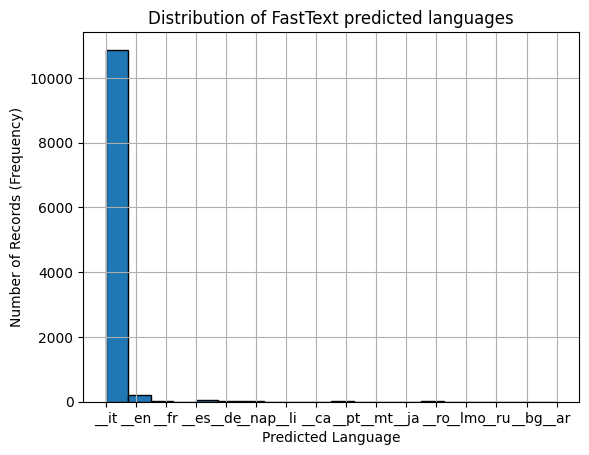

most_probable_language
__it     10871
__en       206
__es        51
__fr        11
__de         4
__nap        4
__ro         3
__pt         3
__ca         1
__li         1
__mt         1
__ja         1
__lmo        1
__ru         1
__bg         1
__ar         1
Name: count, dtype: int64


In [ ]:
import pandas as pd
# Assuming df_language is your DataFrame with the 'confidence' column

# Import the necessary plotting library for display
import matplotlib.pyplot as plt 

df_language['most_probable_language'].hist(
    bins=20, # Number of bins (intervals) for the histogram
    edgecolor='black'
)

plt.title('Distribution of FastText predicted languages')
plt.xlabel('Predicted Language')
plt.ylabel('Number of Records (Frequency)')
plt.show()


print(df_language['most_probable_language'].value_counts())
df['language'] = df_language['most_probable_language']

In [ ]:
# 1. Create the boolean mask
df_1_sentence = df['n_sentences'] <= 1

# 2. Count the rows being affected (Correct use of sum())
rows_to_nullify = df_1_sentence.sum()
print(f"The number of rows/values that contain 1 or fewer sentences is: {rows_to_nullify}")

# 3. Define the columns to nullify
linguistic_columns = ['language', 'swear_IT', 'swear_EN', 
                      'swear IT words', 'swear_EN_words', 'n_sentences', 
                      'n_tokens', 'tokens_per_sent', 'avg_token_per_clause', 
                      'explicit', 'lyrics']

# 4. Apply the mask to the DataFrame df (This is the correct operation)
df.loc[df_1_sentence, linguistic_columns] = pd.NA

## album, album_name, album id

While the column album seems more reasonable and coherent, it contains multiple null values.
Some album in "album_name" appear truncated and incomplete.

We decided to keep the normalization for better readability and to have normalized occurrences.

To create a new correct version of the column showing the album relative to every tracks we decided to do 3 major choices:

    #Choice 1 (for null 'album'): Use 'album_name_norm',
    
    #Choice 2 (for Mismatch): Use 'album_norm',
    
    #Choice 3 (for Match): mantain 'album_norm' (the same with 'album_name_norm')

In [23]:
import numpy as np
import random

print("--- Creazione di 'correct_album' ---")

# Applica la normalizzazione alle due colonne originali
df['album_norm'] = normalize_series(df['album'])
df['album_name_norm'] = normalize_series(df['album_name'])

# Definisci le condizioni per la colonna 'correct_album'
conditions = [
    (df['album'].isnull()), # Priorità 1: Se 'album' è nullo...
    (df['album_norm'] != df['album_name_norm']), # Priorità 2: Se c'è mismatch...
    (df['album_norm'] == df['album_name_norm'])  # Priorità 3: Se c'è match...
]

# Definisci le scelte corrispondenti
choices = [
    df['album_name_norm'], # ...usa 'album_name_norm'
    df['album_norm'],      # ...usa 'album_norm'
    df['album_norm']       # ...usa 'album_norm'
]

# Crea la colonna 'correct_album'
df['correct_album'] = np.select(conditions, choices, default=np.nan)
print("Colonna 'correct_album' creata con successo.")


print("\n--- [FASE 3]: Assegnazione di 'id_album_final' (Algoritmo 1-a-1) ---")

# --- 3.1: Preparazione ---

# Ordina gli album per frequenza (dà priorità agli album più grandi)
album_order = df['correct_album'].value_counts().index

# Filtra i dati per creare la mappa dei candidati
df_candidates = df.dropna(subset=['correct_album', 'id_album'])
track_counts = df_candidates.groupby(['correct_album', 'id_album']).size().to_frame('count')

# Ordina i candidati per album e poi per frequenza
track_counts = track_counts.sort_values(['correct_album', 'count'], ascending=[True, False])

# Crea un dizionario di liste di candidati: {'Album': ['id_più_freq', 'id_secondo_più_freq']}
all_id_candidates = track_counts.reset_index().groupby('correct_album')['id_album'].apply(list).to_dict()

# --- 3.2: Esecuzione del Loop ---

used_ids = set() # Set per gli ID già "presi"
final_album_to_id_map = {} # La nostra mappa pulita finale

def generate_new_id():
    new_id = f"ALB{random.randint(100000, 999999)}"
    while new_id in used_ids:
        new_id = f"ALB{random.randint(100000, 999999)}"
    return new_id

print(f"Inizio processamento di {len(album_order)} album per assegnazione ID...")

# Itera sugli album in ordine di priorità
for album_name in album_order:
    
    candidate_ids = all_id_candidates.get(album_name, []) # Lista di ID candidati
    assigned_id = None # Flag

    # Cerca il primo ID valido (non già usato)
    for potential_id in candidate_ids:
        if potential_id not in used_ids:
            assigned_id = potential_id
            used_ids.add(assigned_id) # "Prenota" l'ID
            final_album_to_id_map[album_name] = assigned_id
            break # Passa all'album successivo
    
    # Se non è stato trovato nessun ID valido (o non c'erano candidati)
    if assigned_id is None:
        new_id = generate_new_id()
        used_ids.add(new_id)
        final_album_to_id_map[album_name] = new_id

print("Processamento ID terminato. Mappa 1-a-1 creata.")

# --- 3.3: Applicazione Finale ---

# Applica la mappa pulita al DataFrame
df['id_album_final'] = df['correct_album'].map(final_album_to_id_map)

print("\n--- VERIFICA FINALE ---")

# Controlla la relazione 1-a-1
check_ids_per_album = df.groupby('correct_album')['id_album_final'].nunique()
check_albums_per_id = df.groupby('id_album_final')['correct_album'].nunique()

print(f"Album con più di 1 ID: {(check_ids_per_album > 1).sum()}")
print(f"ID con più di 1 Album: {(check_albums_per_id > 1).sum()}")

print("\n--- Esempio di 10 righe pulite: ---")
print(df[['correct_album', 'id_album', 'id_album_final']].sample(10))

--- Creazione di 'correct_album' ---
Colonna 'correct_album' creata con successo.

--- [FASE 3]: Assegnazione di 'id_album_final' (Algoritmo 1-a-1) ---
Inizio processamento di 1884 album per assegnazione ID...
Processamento ID terminato. Mappa 1-a-1 creata.

--- VERIFICA FINALE ---
Album con più di 1 ID: 0
ID con più di 1 Album: 0

--- Esempio di 10 righe pulite: ---
                          correct_album   id_album id_album_final
id                                                               
TR877516         truman sanremo edition  ALB700526      ALB858660
TR439677                          ranch  ALB884628      ALB884628
TR663662          pompa il mio disstape  ALB220586      ALB220586
TR470196                         killer  ALB249230      ALB249230
TR530840                 penna capitale  ALB671458      ALB671458
TR476506                      bir tawil  ALB581225      ALB581225
TR696967                 la calda notte  ALB689093      ALB689093
TR563453               keta music vo

In [24]:
df['album'] = df['correct_album']
df.drop(columns=['album_name', 'album_norm', 'album_name_norm', 'correct_album'], inplace=True)
df['id_album'] = df['id_album_final']
df.drop(columns=['id_album_final'], inplace=True)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11166 entries, TR934808 to TR552777
Data columns (total 52 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id_artist             11166 non-null  object        
 1   name_artist           11166 non-null  object        
 2   title                 11166 non-null  string        
 3   featured_artists      11166 non-null  object        
 4   language              11061 non-null  category      
 5   album                 11161 non-null  object        
 6   stats_pageviews       4642 non-null   float64       
 7   swear_IT              11166 non-null  int64         
 8   swear_EN              11166 non-null  int64         
 9   swear_IT_words        11166 non-null  object        
 10  swear_EN_words        11166 non-null  object        
 11  year                  10728 non-null  float64       
 12  month                 9969 non-null   float64       
 13  day        

## Stats page views

As considered in data understanding phase, almost 60% of records is missing (Nan) so we decided to drop the column.

In [26]:
df.drop(columns=['stats_pageviews'], inplace=True)

## Year, Month, Day and Album Release Date

there are multiple nan occurrences in month and day column so we decided to set such records at 01 to create a proper date based on the year.

In [27]:
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df['month'] = pd.to_numeric(df['month'], errors='coerce')
df['day'] = pd.to_numeric(df['day'], errors='coerce')

date_components = {
    'year': df['year'],  
    'month': df['month'].fillna(1),  
    'day': df['day'].fillna(1)        
}

df['date'] = pd.to_datetime(date_components, 
                                    errors='coerce') 
df.drop(columns=['year', 'month', 'day'], inplace=True)

In [28]:
df_release=df

In [29]:
condizione= (df_release['date'] > pd.Timestamp.now()) | (df_release['date'].isna()) | (df_release['date']<df_release['active_start'])
df_release.loc[condizione, 'date'] = df_release.loc[condizione, 'album_release_date']

In [30]:
condizione= (df_release['album_release_date'] > pd.Timestamp.now()) | (df_release['album_release_date'].isna()) | (df_release['album_release_date']<df_release['active_start'])
df_release.loc[condizione, 'album_release_date'] = df_release.loc[condizione, 'date']

After cleaning and filtering the dataset, the columns of album_release_date and date are redundant and both provide the same information on when did the track released.

We decided to use both column to correct the missing and non valid data and selected the best mode of the tracks in the same album (not the tracks with album_type=single) between the date mode and album_release_date mode.

Then we create the column release_date that has the same data for all the tracks in the same album (selected with the previous control) and for singles we decided to use the column date because of more accuracy in the "mode test".

In [31]:
group_keys = ['album'] 
def get_best_mode_info(group):
    """
    Calcola la moda e la frequenza per 'date' e 'album_release_date'
    e restituisce SIA LA FONTE ('date'/'album_release_date') 
    SIA IL VALORE (la data).
    """
    # Calcola mode e frequenze per 'date'
    date_counts = group['date'].value_counts()
    date_mode_freq = date_counts.iloc[0] if not date_counts.empty else 0
    date_mode_value = date_counts.index[0] if not date_counts.empty else pd.NaT

    # Calcola mode e frequenze per 'album_release_date'
    release_counts = group['album_release_date'].value_counts()
    release_mode_freq = release_counts.iloc[0] if not release_counts.empty else 0
    release_mode_value = release_counts.index[0] if not release_counts.empty else pd.NaT

    # Confronta le frequenze e definisci fonte e valore
    if date_mode_freq > release_mode_freq:
        source = 'date'
        value = date_mode_value
    elif release_mode_freq > date_mode_freq:
        source = 'album_release_date'
        value = release_mode_value
    elif date_mode_freq == 0: # Nessun dato valido
        source = 'none'
        value = pd.NaT
    else: 
        # Pareggio (date_mode_freq == release_mode_freq > 0)
        source = 'date' # Scegliamo 'date' come preferenza
        value = date_mode_value
    
    # Restituisci una Serie con entrambe le info
    return pd.Series({
        'best_mode_source': source, 
        'correct_release_date': value
    })

# 4. Calcola le info migliori per ogni gruppo (album)
print("Calcolo della moda migliore per ciascun album...")
# best_album_info ora sarà un DataFrame con colonne 'best_mode_source' e 'correct_release_date'
best_album_info = df_release.groupby(group_keys).apply(get_best_mode_info)

print("\n--- Conteggio finale delle fonti scelte ---")
final_counts = best_album_info['best_mode_source'].value_counts()
print(final_counts)

# Unisci (merge) questo DataFrame al DataFrame originale
# Pandas unirà 'best_mode_source' e 'correct_release_date'
df_release = df_release.merge(best_album_info, on=group_keys, how='left')

print("\nFatto! Colonne 'correct_release_date' e 'best_mode_source' aggiunte.")

# Controlla il risultato (mostrando tutte le colonne rilevanti)
print("\n--- Esempio di 10 righe casuali ---")
print(df_release.sample(n=10)[['album', 'date', 'album_release_date', 'correct_release_date']])

Calcolo della moda migliore per ciascun album...

--- Conteggio finale delle fonti scelte ---
best_mode_source
date                  1353
album_release_date     528
none                     3
Name: count, dtype: int64

Fatto! Colonne 'correct_release_date' e 'best_mode_source' aggiunte.

--- Esempio di 10 righe casuali ---
                                                   album       date  \
7039                                              davide 2017-12-15   
2441                                    realta aumentata 2016-11-04   
8814                                           bipopular 2018-04-27   
10838  sig brainwash larte di accontentare diamond ed... 2013-03-05   
6777                    nesliving vol iv il seme cattivo 2023-03-10   
9630                                     estate dimmerda 2017-07-21   
8194                                           back home 2018-02-02   
3168                             emergenza mixtape vol 1 2013-09-15   
9666                        the isla

In [32]:
print(df_release.sample(n=10)[['album', 'date', 'album_release_date', 'correct_release_date']])

                               album       date album_release_date  \
4292                        sushi ep 2007-11-13         2007-11-13   
3412        la riconquista del forum 2003-11-14         2003-11-04   
8992                           twins 2017-06-23         2017-06-23   
10230   langelo da unala sola atto 2 2006-09-15         2020-10-02   
3028                          caerle 2024-04-02         2024-01-19   
6788                    lamore e qui 2010-09-28         2010-01-01   
4276          street collection vol2 2019-10-25         2019-10-25   
6751         nesliving vol 2 fragile 2009-11-13         2009-11-13   
3586   neffa i messaggeri della dopa 1996-05-14         1996-01-01   
5122     il cielo non e un limite ep 2020-11-13         2016-10-25   

      correct_release_date  
4292            2007-11-13  
3412            2003-11-04  
8992            2017-06-23  
10230           2006-01-01  
3028            2024-04-02  
6788            2010-01-01  
4276            2019-10-25

In [33]:
condizione = (df_release['album_type'] == 'single')
df_release.loc[condizione, 'correct_release_date'] = df_release.loc[condizione, 'date']

In [34]:
group_keys = ['album'] 

best_album_info_df = df.groupby(group_keys).apply(get_best_mode_info)

df = df.merge(best_album_info_df, on=group_keys, how='left')
df.rename(columns={'correct_release_date': 'release_date'}, inplace=True)


print("\nDataFrame 'df' cleaned!")
print(df.sample(n=10))


DataFrame 'df' cleaned!
         id_artist    name_artist               title featured_artists  \
5711   ART26418649          shade  Deadpool Freestyle                    
8598   ART89596800          rkomi            Mirko no                    
6747   ART07629990          nesli  Outro: A Me Stesso                    
10707  ART52465778  fred de palma               Adiós                    
9439   ART56967402   samuel costa           PICAPOLLO                    
8222   ART40433104         madman      Niente Proprio                    
9471   ART46851094      dani faiv            Scompaio                    
9836   ART98118784       tormento        Non smettere                    
10140  ART64850829          shiva         INTRO VERSO                    
5998   ART86549066     emis killa       Sensi in coma                    

      language                album  swear_IT  swear_EN  \
5711        it             kamikaze         3         0   
8598        it          io in terra       

In [35]:
condizione= (df['release_date'] > pd.Timestamp.now()) | (df['release_date'].isna()) | (df['release_date']<df['active_start'])
dati_filtrati = df.loc[condizione, ['release_date', 'album','active_start']]
dati_filtrati

,release_date,album,active_start
289,2010-08-23,the interview,2015-01-01
436,1975-09-12,wish you were here,2012-01-01
1142,2012-01-01,erbavoglio,2013-01-01
1162,2008-04-15,dinamite,2013-01-01
2304,NaT,<NA>,2009-01-01
3680,NaT,<NA>,1991-01-01
3711,NaT,zora la vampira,1991-01-01
3734,NaT,<NA>,1991-01-01
3738,NaT,<NA>,1991-01-01
4601,1933-12-21,balances options,2002-01-01


In [36]:
df[df['album']=='scienza doppia h']

,id_artist,name_artist,title,featured_artists,language,album,swear_IT,swear_EN,swear_IT_words,swear_EN_words,n_sentences,n_tokens,tokens_per_sent,char_per_tok,lexical_density,avg_token_per_clause,bpm,centroid,rolloff,flux,rms,zcr,flatness,spectral_complexity,pitch,loudness,album_release_date,album_type,disc_number,track_number,duration_ms,explicit,popularity,album_image,id_album,lyrics,modified_popularity,gender,birth_date,birth_place,nationality,description,active_start,province,region,country,latitude,longitude,date,best_mode_source,release_date
9120,ART85821920,colle der fomento,Il cielo su Roma,,it,scienza doppia h,2,0,"[sega, stupida]",[],89.0,725.0,8.146067,3.875362,0.463768,7.107843,95.00,0.1350,1505.1086,1.3623,0.1172,0.0613,0.9539,21.8780,2005.7467,9.6318,1999-01-01,album,1,9,288066.0,False,42.0,https://i.scdn.co/image/ab67616d0000b273dd31ad...,ALB384607,"Ah, ah, esco di casa e ci sto dentro La mia ci...",False,M,NaT,NaN,NaN,gruppo musicale italiano,NaT,NaN,NaN,NaN,NaN,NaN,1999-01-01,date,1999-01-01
9134,ART85821920,colle der fomento,Il tuo diavolo,,it,scienza doppia h,1,1,[fregare],[nude],95.0,822.0,8.652632,4.175866,0.450578,5.337662,87.96,0.1125,1190.9466,1.4765,0.1761,0.0468,0.9290,19.2274,2558.6629,17.5232,1999-01-01,album,1,13,295932.0,False,19.0,https://i.scdn.co/image/ab67616d0000b273dd31ad...,ALB384607,"Sempre, sempre con me, sempre contro di me Il ...",False,M,NaT,NaN,NaN,gruppo musicale italiano,NaT,NaN,NaN,NaN,NaN,NaN,1999-01-01,date,1999-01-01
9136,ART85821920,colle der fomento,Vita,,it,scienza doppia h,3,0,"[cesso, incazzato, puttana]",[],116.0,893.0,7.698276,3.993910,0.503045,5.993289,96.02,0.0847,1130.9569,1.2475,0.0568,0.0419,0.8494,9.2386,2607.0102,3.8135,1999-01-01,album,1,3,306519.0,True,30.0,https://i.scdn.co/image/ab67616d0000b273dd31ad...,ALB384607,Uh uh Chi c'è? Chi c'è? Sì Chi c'è? Chi c'è-c'...,False,M,NaT,NaN,NaN,gruppo musicale italiano,NaT,NaN,NaN,NaN,NaN,NaN,1999-01-01,date,1999-01-01
9151,ART85821920,colle der fomento,Prova microfono,,it,scienza doppia h,3,0,"[cazzo, selvaggio, toro]",[],128.0,1115.0,8.710938,4.081192,0.484070,6.798780,90.11,0.0999,1797.8709,1.3868,0.2196,0.0625,0.3275,28.8479,2578.8910,24.0631,1999-01-01,album,1,2,331586.0,False,24.0,https://i.scdn.co/image/ab67616d0000b273dd31ad...,ALB384607,"Uno, due, uno, provo i microfoni Questo è il s...",False,M,NaT,NaN,NaN,gruppo musicale italiano,NaT,NaN,NaN,NaN,NaN,NaN,1999-01-01,date,1999-01-01
9160,ART85821920,colle der fomento,Toro scatenato,,it,scienza doppia h,7,1,"[cazzo, toro]",[hardcore],100.0,862.0,8.620000,3.887728,0.479112,6.338235,91.82,0.0902,1136.0479,1.1172,0.1409,0.0445,0.9489,23.4387,1833.1263,13.4173,1999-01-01,album,1,8,267932.0,True,20.0,https://i.scdn.co/image/ab67616d0000b273dd31ad...,ALB384607,"Sì, sì, nun se ferma mai Sì, sì, non lo fermi ...",False,M,NaT,NaN,NaN,gruppo musicale italiano,NaT,NaN,NaN,NaN,NaN,NaN,1999-01-01,date,1999-01-01
9164,ART85821920,colle der fomento,King Kong vs. Godzilla,,it,scienza doppia h,1,0,[cazzo],[],87.0,703.0,8.080460,4.345291,0.517190,6.333333,172.27,0.0850,918.0454,1.0980,0.1443,0.0356,0.9297,17.7669,2558.4015,14.0608,1999-01-01,album,1,12,303346.0,True,14.0,https://i.scdn.co/image/ab67616d0000b273dd31ad...,ALB384607,Mi arrampico come King Kong su un palazzo Se p...,False,M,NaT,NaN,NaN,gruppo musicale italiano,NaT,NaN,NaN,NaN,NaN,NaN,1999-01-01,date,1999-01-01
9166,ART85821920,colle der fomento,Spinto da una sensazione,esa,it,scienza doppia h,0,0,[],[],79.0,709.0,8.974684,4.161339,0.484018,7.463158,85.17,0.1204,1782.5932,1.5195,0.1102,0.0635,0.8078,14.6565,2713.2143,9.8978,1999-01-01,album,1,10,349052.0,False,12.0,https://i.scdn.co/image/ab67616d0000b273dd31ad...,ALB384607,"Uh, uh Eh sì eh, eh sì eh Check uno-due com'è ...",False,M,NaT,NaN,NaN,gruppo musicale italiano,NaT,NaN,NaN,NaN,NaN,NaN,1999-01-01,date,1999-01-01
9169,ART85821920,colle der fomento,Scienza doppia H,,it,scienza doppia h,0,0,[],[],104.0,957.0,9.201923,4.143017,0.501676,6.787234,172.27,0.1127,1611.4928,

In [37]:
condizione= (df['release_date'].isna()) | (df['release_date']<df['active_start'])
df.loc[condizione, 'release_date'] = pd.NaT

Active start was remodeled and filled the first date recorded of their tracks/albums.

In [38]:
df['active_start'] = df['active_start'].fillna(
    df.groupby('name_artist')['release_date'].transform('min')
)

In [39]:
col_drop = ['album_release_date', 'date', 'best_mode_source','new_release']
df.drop(columns=col_drop, inplace=True, errors='ignore')

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11166 entries, 0 to 11165
Data columns (total 48 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id_artist             11166 non-null  object        
 1   name_artist           11166 non-null  object        
 2   title                 11166 non-null  string        
 3   featured_artists      11166 non-null  object        
 4   language              11061 non-null  category      
 5   album                 11161 non-null  object        
 6   swear_IT              11166 non-null  int64         
 7   swear_EN              11166 non-null  int64         
 8   swear_IT_words        11166 non-null  object        
 9   swear_EN_words        11166 non-null  object        
 10  n_sentences           11090 non-null  float64       
 11  n_tokens              11090 non-null  float64       
 12  tokens_per_sent       11090 non-null  float64       
 13  char_per_tok    

## Popularity and Modified_popularity

When modified_popularity is 'true' (78 occurrences) the related popularity occurrence is not in the correct format.
We decided to drop the column modified_popularity and set the invalid popularity records to NaN.

In [41]:
pop=df[df['modified_popularity']==True]
print(len(pop))

78


In [42]:
condizione= (df['popularity']<0) | (df['popularity']>100) | (df['popularity'].isna())
dati_filtrati = df.loc[condizione, ['popularity', 'modified_popularity']]
dati_filtrati

,popularity,modified_popularity
1932,NaN,True
2304,NaN,True
3286,-654.0,True
3667,147413.0,True
3668,164032.0,True
...,...,...
3737,NaN,True
3738,884794.0,True
3739,-119.0,True
6390,-606.0,True


In [43]:
condizione= (df['popularity']<0) | (df['popularity']>100)
df.loc[condizione, 'popularity'] = np.nan
df.drop(columns=['modified_popularity'], inplace=True)

## Swear words control

We checked if the column Swear_IT and Swear_EN are coherent with the lyrics and their related Swear_IT_words and Swear_EN_words lists.

In [44]:
import re
from pandas.api.types import is_scalar # Importiamo il controllo specifico

## 1. Funzione per contare le parole nel testo (Versione 3)

def conta_parole_in_testo_corretto(riga):
    lista_parole = riga['swear_IT_words']
    testo_lyrics = riga['lyrics']

    # --- CORREZIONE ---
    # 1. Controlla il testo (che è sempre scalare)
    if pd.isna(testo_lyrics):
        return 0

    # 2. Controlla la lista/array
    # Prima controlla se è uno scalare (es. np.nan o None)
    if is_scalar(lista_parole):
        if pd.isna(lista_parole):
            return 0  # È np.nan o None, quindi 0
        else:
            return 0  # È uno scalare ma non nullo (es. un numero), non va bene
    
    # Se siamo qui, 'lista_parole' NON è uno scalare,
    # quindi è una lista o un array. Ora possiamo controllarne la lunghezza.
    if len(lista_parole) == 0:
        return 0
    # --- FINE CORREZIONE ---

    conteggio_totale = 0
    testo_lower = testo_lyrics.lower()

    for parola in lista_parole:
        parola_lower = str(parola).lower()
        pattern = r'\b' + re.escape(parola_lower) + r'\b'
        occorrenze = re.findall(pattern, testo_lower)
        conteggio_totale += len(occorrenze)

    return conteggio_totale

# --- ESECUZIONE DEL CONTROLLO ---

# 1. Calcola il nuovo conteggio applicando la funzione CORRETTA
print("1/3: Riconteggio delle parole nei testi (può richiedere tempo)...")
df['conteggio_calcolato'] = df.apply(conta_parole_in_testo_corretto, axis=1)

# 2. Prepara il conteggio originale
df['conteggio_originale'] = df['swear_IT'].fillna(0).astype(int)

# 3. Confronta i due conteggi
print("2/3: Confronto dei conteggi...")
incoerenze = df[df['conteggio_originale'] != df['conteggio_calcolato']]

# --- RISULTATO ---
print("3/3: Controllo completato.")
if incoerenze.empty:
    print("\n✅ Controllo superato! Tutti i conteggi 'swear_IT' corrispondono al ricalcolo dai testi.")
else:
    print(f"\n⚠️ Trovate {len(incoerenze)} righe incoerenti:")
    print(incoerenze[['artist', 'title', 'conteggio_originale', 'conteggio_calcolato', 'swear_IT_words']])

1/3: Riconteggio delle parole nei testi (può richiedere tempo)...
2/3: Confronto dei conteggi...
3/3: Controllo completato.

✅ Controllo superato! Tutti i conteggi 'swear_IT' corrispondono al ricalcolo dai testi.


In [45]:
import re
from pandas.api.types import is_scalar # Importiamo il controllo specifico

## 1. Funzione per contare le parole nel testo (Versione 3)

def conta_parole_in_testo_corretto(riga):
    lista_parole = riga['swear_EN_words']
    testo_lyrics = riga['lyrics']

    # --- CORREZIONE ---
    # 1. Controlla il testo (che è sempre scalare)
    if pd.isna(testo_lyrics):
        return 0

    # 2. Controlla la lista/array
    # Prima controlla se è uno scalare (es. np.nan o None)
    if is_scalar(lista_parole):
        if pd.isna(lista_parole):
            return 0  # È np.nan o None, quindi 0
        else:
            return 0  # È uno scalare ma non nullo (es. un numero), non va bene
    
    # Se siamo qui, 'lista_parole' NON è uno scalare,
    # quindi è una lista o un array. Ora possiamo controllarne la lunghezza.
    if len(lista_parole) == 0:
        return 0
    # --- FINE CORREZIONE ---

    conteggio_totale = 0
    testo_lower = testo_lyrics.lower()

    for parola in lista_parole:
        parola_lower = str(parola).lower()
        pattern = r'\b' + re.escape(parola_lower) + r'\b'
        occorrenze = re.findall(pattern, testo_lower)
        conteggio_totale += len(occorrenze)

    return conteggio_totale

# --- ESECUZIONE DEL CONTROLLO ---

# 1. Calcola il nuovo conteggio applicando la funzione CORRETTA
print("1/3: Riconteggio delle parole nei testi (può richiedere tempo)...")
df['conteggio_calcolato'] = df.apply(conta_parole_in_testo_corretto, axis=1)

# 2. Prepara il conteggio originale
df['conteggio_originale'] = df['swear_EN'].fillna(0).astype(int)

# 3. Confronta i due conteggi
print("2/3: Confronto dei conteggi...")
incoerenze = df[df['conteggio_originale'] != df['conteggio_calcolato']]

# --- RISULTATO ---
print("3/3: Controllo completato.")
if incoerenze.empty:
    print("\n✅ Controllo superato! Tutti i conteggi 'swear_EN' corrispondono al ricalcolo dai testi.")
else:
    print(f"\n⚠️ Trovate {len(incoerenze)} righe incoerenti:")
    print(incoerenze[['artist', 'title', 'conteggio_originale', 'conteggio_calcolato', 'swear_EN_words']])

1/3: Riconteggio delle parole nei testi (può richiedere tempo)...
2/3: Confronto dei conteggi...
3/3: Controllo completato.

✅ Controllo superato! Tutti i conteggi 'swear_EN' corrispondono al ricalcolo dai testi.


In [46]:
lista_parole_it = list(df['swear_IT_words'].explode().dropna().unique())

# 2. Lista Inglese (EN)
# Stessa identica logica
lista_parole_en = list(df['swear_EN_words'].explode().dropna().unique())

# 3. Stampa i risultati
print(f"--- PAROLE UNICHE ITALIANE ({len(lista_parole_it)}) ---")
print(lista_parole_it)


--- PAROLE UNICHE ITALIANE (173) ---
['cazzo', 'cesso', 'coglioni', 'figa', 'merda', 'palle', 'piscio', 'porca', 'stronzo', 'culo', 'frocio', 'puttana', 'sega', 'troia', 'bastardo', 'fottere', 'pompino', 'scopare', 'figo', 'cagare', 'fica', 'gay', 'zoccola', 'coglione', 'puttano', 'fottuto', 'cazzi', 'ricchione', 'stupido', 'vagina', 'selvaggio', 'fottuti', 'incazzato', 'cretino', 'sboccare', 'zanzara', 'fortuna', 'stupida', 'incazzare', 'cagna', 'grilletto', 'bastardi', 'toro', 'pippa', 'cazzata', 'sedere', 'mazzo', 'cretini', 'vaffanculo', 'fogne', 'scazzo', 'cogliona', 'cozza', 'jug', 'puttanata', 'sfiga', 'pisciare', 'scopata', 'checca', 'fesso', 'madonna', 'scassare', 'uccello', 'sfigata', 'battona', 'fregna', 'topa', 'pisciata', 'bagascia', 'maiala', 'mignotta', 'farabutto', 'chiappa', 'minchioni', 'fico', 'travestito', 'vacca', 'gnocca', 'bischero', 'idiozia', 'handicappato', 'leccaculo', 'pene', 'fregarsene', 'paraculo', 'bocchino', 'farabutti', 'granchio', 'blowjob', 'cappella

In [47]:

print(f"\n--- PAROLE UNICHE INGLESI ({len(lista_parole_en)}) ---")
print(lista_parole_en)


--- PAROLE UNICHE INGLESI (96) ---
['bitch', 'fuck', 'porno', 'pussy', 'escort', 'negro', 'sex', 'sexy', 'shit', 'bastardo', 'bitches', 'cock', 'ass', 'slut', 'voyeur', 'anal', 'tranny', 'dick', 'nigga', 'threesome', 'vagina', 'porn', 'clit', 'nude', 'fucking', 'bullshit', 'motherfucker', 'xx', 'boobs', 'xxx', 'playboy', 'deepthroat', 'faggot', 'fisting', 'suck', 'cumming', 'milf', 'hardcore', 'cialis', 'fag', 'rapist', 'rape', 'dildo', 'viagra', 'rimming', 'sexo', 'hentai', 'blowjob', 'fuckin', 'gangbang', 'pedobear', 'fellatio', 'bastard', 'sexual', 'snatch', 'butt', 'cumshot', 'lolita', 'vulva', 'punany', 'panties', 'shitty', 'tits', 'topless', 'anus', 'bbw', 'bondage', 'cunt', 'scat', 'raping', 'shibari', 'poof', 'coon', 'skeet', 'domination', 'ecchi', 'sucks', 'creampie', 'cum', 'titty', 'spic', 'kinky', 'bukkake', 'cocks', 'pissing', 'asshole', 'busty', 'hooker', 'semen', 'horny', 'masturbation', 'neonazi', 'doggystyle', 'tit', 'nympho', 'nipple']


In [48]:
condizione= (df['explicit']==False) & ((df['swear_IT']>0) | (df['swear_EN']>0))
dati_filtrati = df.loc[condizione, ['explicit', 'swear_IT', 'swear_EN']]
dati_filtrati
df.loc[condizione,['explicit']] = True

In [49]:
condizione= (df['explicit']==True) & ((df['swear_IT']==0) & (df['swear_EN']==0))
dati_filtrati = df.loc[condizione, ['explicit', 'swear_IT', 'swear_EN']]
dati_filtrati
df.loc[condizione,['explicit']] = False

In [50]:
df_swear=df
## 1. Preparazione: Creare i Pattern RegEx
#    Questa è la parte più importante per la velocità.
#    Trasformiamo ['a', 'b', 'c'] in r'\b(a|b|c)\b'

def crea_pattern(lista_parole):
    # 1. Assicura che siano tutte stringhe e minuscole
    parole_pulite = [str(p).lower() for p in lista_parole if pd.notna(p)]
    
    # 2. Fai l'escape di ogni parola (per gestire caratteri come 'f**k')
    parole_escaped = [re.escape(p) for p in parole_pulite]
    
    # 3. Uniscile con un OR (|)
    pattern_string = "|".join(parole_escaped)
    
    # 4. Racchiudi in \b (word boundary) per trovare solo parole intere
    #    e compila il pattern RegEx.
    return re.compile(r'\b(' + pattern_string + r')\b', re.IGNORECASE)

print("Creazione pattern RegEx in corso...")
pattern_it = crea_pattern(lista_parole_it)
pattern_en = crea_pattern(lista_parole_en)
print("Pattern creati.")


## 2. Definire la Funzione di Ricalcolo
#    Questa funzione verrà applicata a OGNI RIGA del DataFrame

def ricalcola_parole(riga):
    testo = riga['lyrics']
    
    # Se il testo è mancante, restituisci valori vuoti
    if pd.isna(testo):
        return 0, [], 0, [] # count_it, words_it, count_en, words_en

    # --- Processo Italiano ---
    # re.findall() trova TUTTE le occorrenze (anche duplicate)
    matches_it = pattern_it.findall(testo.lower())
    
    # Il conteggio è il numero totale di occorrenze
    conteggio_it = len(matches_it)
    # La lista di parole è l'insieme unico (set) delle parole trovate
    parole_uniche_it = list(set(matches_it))

    # --- Processo Inglese ---
    matches_en = pattern_en.findall(testo.lower())
    conteggio_en = len(matches_en)
    parole_uniche_en = list(set(matches_en))

    return conteggio_it, parole_uniche_it, conteggio_en, parole_uniche_en


## 3. Esecuzione e Aggiornamento
#    Applichiamo la funzione all'intero DataFrame

print("Inizio ricalcolo su tutto il DataFrame (può richiedere tempo)...")

# 'axis=1' applica la funzione a ogni riga
# 'result_type='expand'' divide il risultato della funzione (i 4 valori)
# in 4 nuove colonne
nuovi_valori = df_swear.apply(ricalcola_parole, axis=1, result_type='expand')

nuovi_valori.columns = ['swear_IT_new', 'swear_IT_words_new', 'swear_EN_new', 'swear_EN_words_new']

# Confrontiamo le vecchie colonne con le nuove
# Usiamo .fillna(0) per i conteggi e .ne() (Not Equal) per le liste

# 1. Confronto Conteggi
cond_it_count = df_swear['swear_IT'].fillna(0).ne(nuovi_valori['swear_IT_new'])
cond_en_count = df_swear['swear_EN'].fillna(0).ne(nuovi_valori['swear_EN_new'])

# 2. Confronto Liste
# .ne() gestisce correttamente il confronto tra liste e valori NaN/None
cond_it_words = df_swear['swear_IT_words'].ne(nuovi_valori['swear_IT_words_new'])
cond_en_words = df_swear['swear_EN_words'].ne(nuovi_valori['swear_EN_words_new'])

# 3. Condizione Totale: la riga è cambiata se ALMENO UNO dei 4 campi è diverso
condizione_cambiati = (cond_it_count | cond_en_count | cond_it_words | cond_en_words)

# 4. Stampa e Copia (come richiesto)
num_cambiati = condizione_cambiati.sum()
print(f"📊 Numero di record che verranno aggiornati: {num_cambiati}")

# Creiamo la copia delle righe *originali* che stanno per cambiare
df_swear_copy = df_swear[condizione_cambiati].copy()
print(f"📋 Creato 'df_swear_copy' con {len(df_swear_copy)} record (lo stato *prima* della modifica).")

# Assegna i nuovi valori alle colonne corrette del DataFrame originale
# (sovrascrivendo i vecchi dati)
df_swear[['swear_IT', 'swear_IT_words', 'swear_EN', 'swear_EN_words']] = nuovi_valori

print("Ricalcolo completato! Le colonne sono state aggiornate.")


Creazione pattern RegEx in corso...
Pattern creati.
Inizio ricalcolo su tutto il DataFrame (può richiedere tempo)...
📊 Numero di record che verranno aggiornati: 2943
📋 Creato 'df_swear_copy' con 2943 record (lo stato *prima* della modifica).
Ricalcolo completato! Le colonne sono state aggiornate.


We discovered that the dataset was probably created by starting with a fixed swear words list but this list doesn't include plural and leads to not accurate records both in the swear_word collection, count and the explicit column.
We decided to just fix the explicit column according to our swear words counts and not manually insert the plural or the other word forms in the database.

In [52]:
df.drop(columns=['conteggio_calcolato', 'conteggio_originale'], inplace=True)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11166 entries, 0 to 11165
Data columns (total 47 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id_artist             11166 non-null  object        
 1   name_artist           11166 non-null  object        
 2   title                 11166 non-null  string        
 3   featured_artists      11166 non-null  object        
 4   language              11061 non-null  category      
 5   album                 11161 non-null  object        
 6   swear_IT              11166 non-null  int64         
 7   swear_EN              11166 non-null  int64         
 8   swear_IT_words        11166 non-null  object        
 9   swear_EN_words        11166 non-null  object        
 10  n_sentences           11090 non-null  float64       
 11  n_tokens              11090 non-null  float64       
 12  tokens_per_sent       11090 non-null  float64       
 13  char_per_tok    